<a href="https://colab.research.google.com/github/efedikmen/Airbnb-NYC-Pricing-Recommender-Project/blob/main/Copy_of_AirBnB_Streamlit_App.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run streamlit app from a Google Colab Notebook
> Adapted from https://medium.com/@jcharistech/how-to-run-streamlit-apps-from-colab-29b969a1bdfc

In [ ]:
!pip install -q streamlit
!pip install -q pyngrok

     |████████████████████████████████| 133kB 31.0MB/s 
ERROR: pysal 2.4.0 has requirement urllib3>=1.26, but you'll have urllib3 1.25.11 which is incompatible.
ERROR: google-colab 1.0.0 has requirement ipykernel~=4.10, but you'll have ipykernel 5.5.5 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


Reset the execution environment after streamlit installation



# Framework for Streamlit dashboard


In [ ]:
# Install the SQLAlchemy library if it is not installed
!sudo apt-get install python3-dev libmysqlclient-dev > /dev/null
!pip install mysqlclient > /dev/null
!sudo pip3 install -U sql_magic > /dev/null
!pip install psycopg2-binary > /dev/null
!pip3 install -U geopandas fiona shapely pyproj geopy pysal descartes
!curl 'https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Community_Districts/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json' -o nyc-neighborhoods.geojson

Requirement already up-to-date: geopandas in /usr/local/lib/python3.7/dist-packages (0.9.0)
Requirement already up-to-date: fiona in /usr/local/lib/python3.7/dist-packages (1.8.19)
Requirement already up-to-date: shapely in /usr/local/lib/python3.7/dist-packages (1.7.1)
Requirement already up-to-date: pyproj in /usr/local/lib/python3.7/dist-packages (3.0.1)
Requirement already up-to-date: geopy in /usr/local/lib/python3.7/dist-packages (2.1.0)
Requirement already up-to-date: pysal in /usr/local/lib/python3.7/dist-packages (2.4.0)
Requirement already up-to-date: descartes in /usr/local/lib/python3.7/dist-packages (1.1.0)
  Using cached https://files.pythonhosted.org/packages/09/c6/d3e3abe5b4f4f16cf0dfc9240ab7ce10c2baa0e268989a4e3ec19e90c84e/urllib3-1.26.4-py2.py3-none-any.whl
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.4 which is incompatible.
ERROR: google-colab 1.0.0 has requirement ipykernel~=4.10, but you'll have ipyke

In [ ]:
%%writefile app.py

import streamlit as st
import pandas as pd
from cachetools import cached
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from sqlalchemy import create_engine

conn_string = 'mysql://{user}:{password}@{host}:{port}/{db}?charset=utf8'.format(
    user='Binary_beasts', 
    password='gYbkCO6o3CA=', 
    host = 'jsedocc7.scrc.nyu.edu', 
    port     = 3306, 
    encoding = 'utf-8',
    db = 'airbnb'
)

engine = create_engine(conn_string)

PAGE_CONFIG = {"page_title":"More Examples","page_icon":":smiley:","layout":"centered"}
st.set_page_config(**PAGE_CONFIG)

def main():
    st.title("New York City AirBnB Pricing Guide")
    st.subheader("Inform pricing choices. Visualize historical trends.")
    menu = ["Home", "Pricing Tool","Visualization"] #we can label these with the topic that the page will display
    choice = st.sidebar.selectbox('Navigation', menu)
    if choice == 'Pricing Tool':
        st.subheader("How to Price My Listing")
        text = "Input information about your listing to determine a fair price. Description of how the algorithm works."
        st.write(text)

        arr = np.random.normal(1, 1, size=100)
        fig, ax = plt.subplots()
        ax.hist(arr, bins=20)
        st.pyplot(fig)

        query = '''SELECT * FROM x;'''
        x = pd.read_sql_query(query, engine)
        query1 = '''SELECT * FROM y;'''
        y = pd.read_sql_query(query1, engine)
        query2 = '''SELECT * FROM Income;'''
        income = pd.read_sql_query(query2, engine)
        query3 = '''SELECT * FROM Rental;'''
        rent = pd.read_sql_query(query3, engine)
        query4 = '''SELECT * FROM Scores;'''
        scores = pd.read_sql_query(query4, engine)

        district_list = income.iloc[:,0].tolist()

        pred = runPricingTool(district_list)
        rfr=RandomForestRegressor(random_state=0,max_depth=20,max_features=5,min_samples_leaf=2,min_samples_split=25,n_estimators=200,n_jobs=-1)
        rfr.fit(x,y.values.ravel())
        p = np.exp(rfr.predict(pred).item(0))
        
        st.write('The recommended price for this listing is', np.round(p), 'USD per night')

    elif choice == 'Visualizations':
      st.subheader('This page could show geographical data by neighborhood')

      query = '''SELECT * FROM (SELECT c.neighbourhood_group,c.latitude,c.longitude,c.room_type,c.price,c.minimum_nights,c.number_of_reviews,c.reviews_per_month,
      c.calculated_host_listings_count,c.availability_365,c.income,c.token, d.rent, d.Location FROM (SELECT * FROM Listings a LEFT JOIN Income b ON a.neighbourhood=b.token) c LEFT JOIN Rental d ON c.token = d.token) x
      LEFT JOIN Scores y ON x.token=y.token;'''
      listings = pd.read_sql_query(query, engine)
      listings = listings[listings["price"]>0]
      listings["logprice"] = np.log(listings["price"])
      listings = listings[listings["logprice"]>3]
      listings = listings[listings["logprice"]<7]
      listings["income"] = listings["income"].astype("int64")
      listings = listings[listings["availability_365"]>0]

      st.map(listings)

    elif choice == 'Home':
        st.subheader('Welcome to our home page')

def input_converter(listing_type:str, district:int, availability_365:int, reviews_per_month:float, minimum_nights:int, num_reviews:int, listings_count:int):
  cols = ['Entire home/apt', 'Private room', 'rent', 'availability_365', 'income',
       'reviews_per_month', 'minimum_nights', 'number_of_reviews', 'walk',
       'bike', 'calculated_host_listings_count']
  X = []
  query2 = '''SELECT * FROM Income;'''
  income = pd.read_sql_query(query2, engine)
  query3 = '''SELECT * FROM Rental;'''
  rent = pd.read_sql_query(query3, engine)
  query4 = '''SELECT * FROM Scores;'''
  scores = pd.read_sql_query(query4, engine)
  if listing_type == 'Entire home/apt':
    X.append(1)
  else:
    X.append(0)
  if listing_type == 'Private room':
    X.append(1)
  else:
    X.append(0)
  X.append(np.log(rent.iloc[district,1]))
  X.append(availability_365)
  X.append(np.log(int(income.iloc[district,1])))
  X.append(reviews_per_month)
  X.append(minimum_nights)
  X.append(num_reviews)
  X.append(scores.iloc[district,1])
  X.append(scores.iloc[district,3])
  X.append(listings_count)
  return pd.DataFrame(X, index=cols).T

def runPricingTool(districts):
  listing_in = st.selectbox('What type of listing?', ('Entire home/apt','Private room', 'Shared room'))
  district_in = st.selectbox('What neighborhood is the listing in?', ('Battery Park/Tribeca','Greenwich Village','Lower East Side','Chelsea/Clinton', 'Midtown Business District','Murray Hill/Stuyvesant','Upper West Side','Upper East Side', 'Manhattanville', 'Central Harlem', 'East Harlem', 'Washington Heights', 'Mott Haven', 'Hunts Point', 'Morrisania', 'Concourse/Highbridge', 'University Heights','East Tremont','Bedford Park', 'Riverdale', 'Unionport/Soundview', 'Throgs Neck', 'Pelham Parkway','Williamsbridge', 'Williamsburg/Greenpoint', 'Fort Greene/Brooklyn Hts', 'Bedford Stuyvesant','Bushwick', 'East New York','Park Slope', 'Sunset Park','Crown Heights North','Crown Heights South', 'Bay Ridge', 'Bensonhurst', 'Borough Park', 'Coney Island','Flatbush/Midwood', 'Sheepshead Bay', 'Brownsville', 'East Flatbush', 'Canarsie', 'Astoria','Sunnyside/Woodside', 'Jackson Heights', 'Elmhurst/Corona', 'Ridgewood/Glendale','Rego Park/Forest Hills', 'Flushing','Fresh Meadows/Briarwood', 'Woodhaven', 'Howard Beach', 'Bayside', 'Jamaica/St. Albans', 'Queens Village', 'The Rockaways', 'St. George', 'South Beach', 'Tottenville'))
  avail_in = st.number_input('How many days in the year is the listing available?', min_value=1, max_value=365, step=1)
  reviewsmonthly_in = st.number_input('How many reviews does this listing receive per month?')
  minnights_in = st.number_input('What is the minimum number of nights per stay?', min_value=1,step=1)
  reviews_in = st.number_input('How many total reviews does the listing have?', step=1)
  listcount_in = st.number_input('How many listings does the host have?', min_value=1, step=1)

  district_numeric = districts.index(district_in)
  X_pred = input_converter(listing_in, district_numeric, avail_in, reviewsmonthly_in, minnights_in, reviews_in, listcount_in)
  
  return X_pred

if __name__ == '__main__':
    main()

Overwriting app.py


In [ ]:
!streamlit run app.py &>/dev/null &

In [ ]:
from pyngrok import ngrok
# Setup a tunnel to the streamlit port 8501
public_url = ngrok.connect(8501)
public_url

# Click link in output to access the website

<NgrokTunnel: "http://94d0d300d00d.ngrok.io" -> "http://localhost:8501">

In [ ]:
# This is to stop the tunnel and streamlit
ngrok.kill()
!pkill streamlit

In [ ]:
# If ngrok isn't working use this.
!npm install localtunnel
!npx localtunnel --port 8501

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.1
updated 1 package and audited 36 packages in 0.471s

3 packages are looking for funding
  run `npm fund` for details

found 0 vulnerabilities

npx: installed 22 in 1.765s
your url is: https://strong-donkey-12.loca.lt
^C


#Code for the algorithm

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sqlalchemy import create_engine
import pandas as pd
import numpy as np

conn_string = 'mysql://{user}:{password}@{host}:{port}/{db}?charset=utf8'.format(
    user='Binary_beasts', 
    password='gYbkCO6o3CA=', 
    host = 'jsedocc7.scrc.nyu.edu', 
    port     = 3306, 
    encoding = 'utf-8',
    db = 'airbnb'
)
engine = create_engine(conn_string)

In [ ]:
%reload_ext sql_magic
%config SQL.conn_name = 'engine'

In [ ]:
query = '''SELECT * FROM x;'''
x = pd.read_sql_query(query, engine)
query1 = '''SELECT * FROM y;'''
y = pd.read_sql_query(query1, engine)
query2 = '''SELECT * FROM Income;'''
income = pd.read_sql_query(query2, engine)
query3 = '''SELECT * FROM Rental;'''
rent = pd.read_sql_query(query3, engine)
query4 = '''SELECT * FROM Scores;'''
scores = pd.read_sql_query(query4, engine)

In [ ]:
district_list = income.iloc[:,0].tolist()

In [ ]:
district_list.index('East Harlem')

10

In [ ]:
rfr=RandomForestRegressor(random_state=0,max_depth=20,max_features=5,min_samples_leaf=2,min_samples_split=25,n_estimators=200,n_jobs=-1)
rfr.fit(x,y.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=25, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [ ]:
def input_converter(listing_type:str, district:int, availability_365:int, reviews_per_month:float, minimum_nights:int, num_reviews:int, listings_count:int):
  cols = ['Entire home/apt', 'Private room', 'rent', 'availability_365', 'income',
       'reviews_per_month', 'minimum_nights', 'number_of_reviews', 'walk',
       'bike', 'calculated_host_listings_count']
  X = []
  if listing_type == 'Entire home/apt':
    X.append(1)
  else:
    X.append(0)
  if listing_type == 'Private room':
    X.append(1)
  else:
    X.append(0)
  X.append(np.log(rent.iloc[district,1]))
  X.append(availability_365)
  X.append(np.log(int(income.iloc[district,1])))
  X.append(reviews_per_month)
  X.append(minimum_nights)
  X.append(num_reviews)
  X.append(scores.iloc[district,1])
  X.append(scores.iloc[district,3])
  X.append(listings_count)
  return pd.DataFrame(X, index=cols).T

In [ ]:
X_pred = input_converter('Shared room', 3, 198, 2.5, 2, 25, 3) 
X_pred

,Entire home/apt,Private room,rent,availability_365,income,reviews_per_month,minimum_nights,number_of_reviews,walk,bike,calculated_host_listings_count
0,0.0,0.0,7.577122,198.0,11.697312,2.5,2.0,25.0,88.25,79.75,3.0


In [ ]:
np.exp(rfr.predict(X_pred).item(0)) # $ per night

80.67095231446348

#Code for Visualizations

In [ ]:
!pip install psycopg2-binary > /dev/null
!pip3 install -U geopandas fiona shapely pyproj geopy pysal descartes

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [ ]:
conn_string = 'mysql://{user}:{password}@{host}:{port}/{db}?charset=utf8'.format(
    user='Binary_beasts', 
    password='gYbkCO6o3CA=', 
    host = 'jsedocc7.scrc.nyu.edu', 
    port     = 3306, 
    encoding = 'utf-8',
    db = 'airbnb'
)
engine = create_engine(conn_string)
%reload_ext sql_magic
%config SQL.conn_name = 'engine'

In [ ]:
query = '''SELECT * FROM (SELECT c.neighbourhood_group,c.latitude,c.longitude,c.room_type,c.price,c.minimum_nights,c.number_of_reviews,c.reviews_per_month,
c.calculated_host_listings_count,c.availability_365,c.income,c.token, d.rent, d.Location FROM (SELECT * FROM Listings a LEFT JOIN Income b ON a.neighbourhood=b.token) c LEFT JOIN Rental d ON c.token = d.token) x
LEFT JOIN Scores y ON x.token=y.token;'''
listings = pd.read_sql_query(query, engine)
listings = listings[listings["price"]>0]
listings["logprice"] = np.log(listings["price"])
listings = listings[listings["logprice"]>3]
listings = listings[listings["logprice"]<7]
listings["income"] = listings["income"].astype("int64")
listings = listings[listings["availability_365"]>0]

In [ ]:
!curl 'https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Community_Districts/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json' -o nyc-neighborhoods.geojson


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3577k  100 3577k    0     0  2124k      0  0:00:01  0:00:01 --:--:-- 2122k


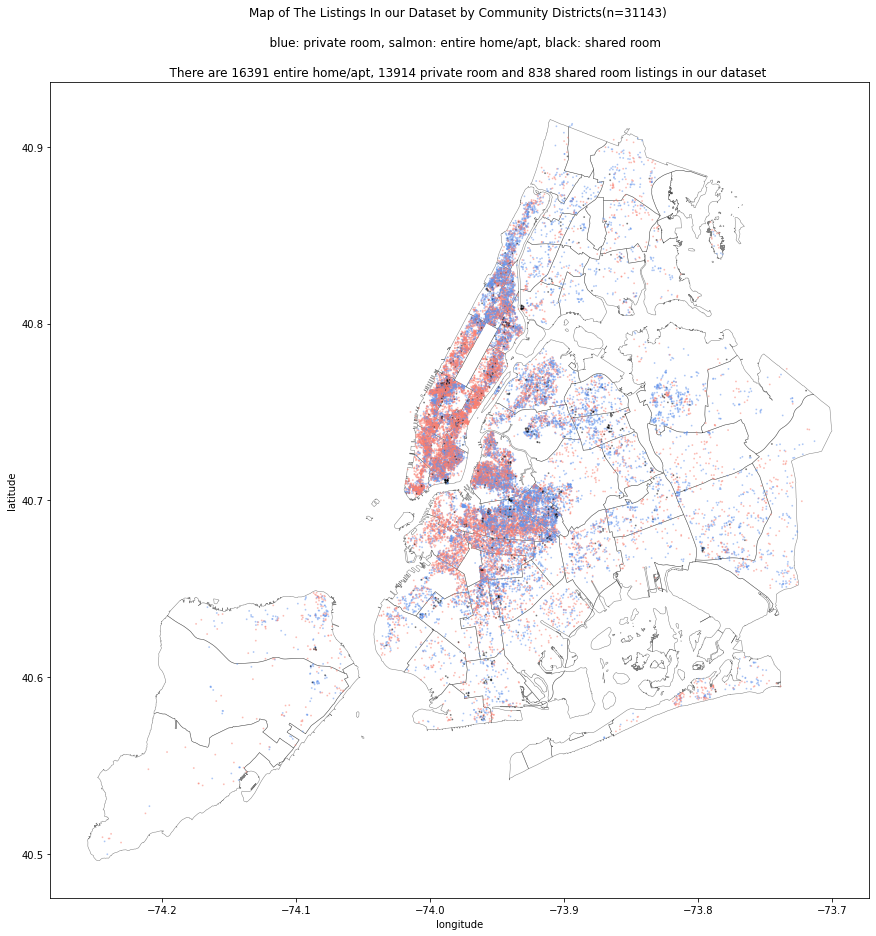

In [ ]:
df_nyc = gpd.GeoDataFrame.from_file('nyc-neighborhoods.geojson')
base = df_nyc.plot(linewidth=0.5, color='White',edgecolor = 'Black', figsize = (15,15), alpha=0.5)

colors = {'Private room':'cornflowerblue', 'Entire home/apt':'salmon', 'Shared room':'black'}
scatterplot = listings.plot(kind='scatter', 
    x = 'longitude', y = 'latitude',
    figsize = (20, 15),
    s = 0.8, alpha = 0.4,
    ax = base, title='''Map of The Listings In our Dataset by Community Districts(n=31143) \n 
    blue: private room, salmon: entire home/apt, black: shared room \n
    There are 16391 entire home/apt, 13914 private room and 838 shared room listings in our dataset''', 
    c=listings['room_type'].apply(lambda x: colors[x])
)

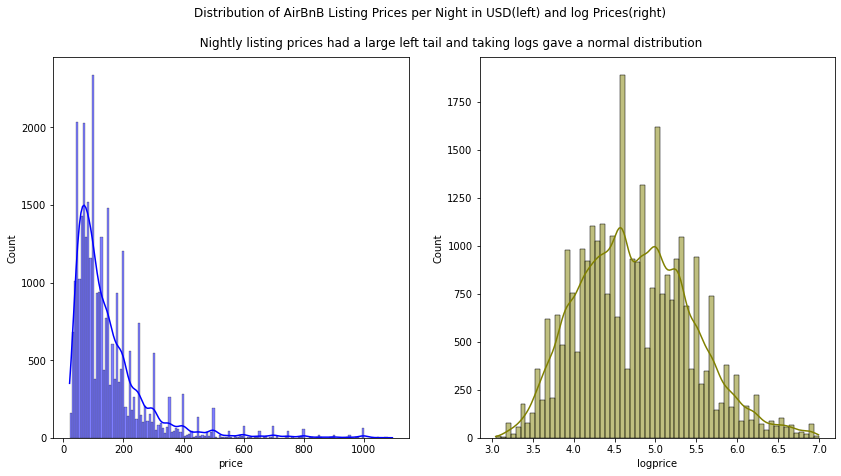

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle('''Distribution of AirBnB Listing Prices per Night in USD(left) and log Prices(right) \n
          Nightly listing prices had a large left tail and taking logs gave a normal distribution''')
sns.histplot(data=listings, x="price", kde=True, color="blue", ax=axs[0], )
sns.histplot(data=listings, x="logprice", kde=True, color="olive", ax=axs[1])

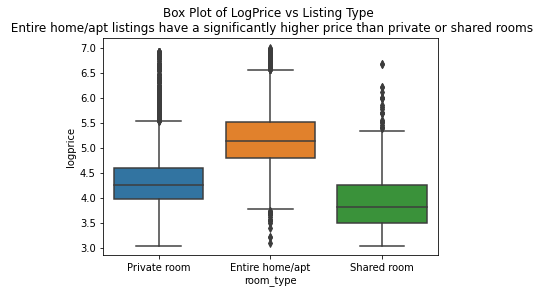

In [ ]:
ax = sns.boxplot(x="room_type", y="logprice", data=listings)
plt.title('Box Plot of LogPrice vs Listing Type \n Entire home/apt listings have a significantly higher price than private or shared rooms')
plt.show()

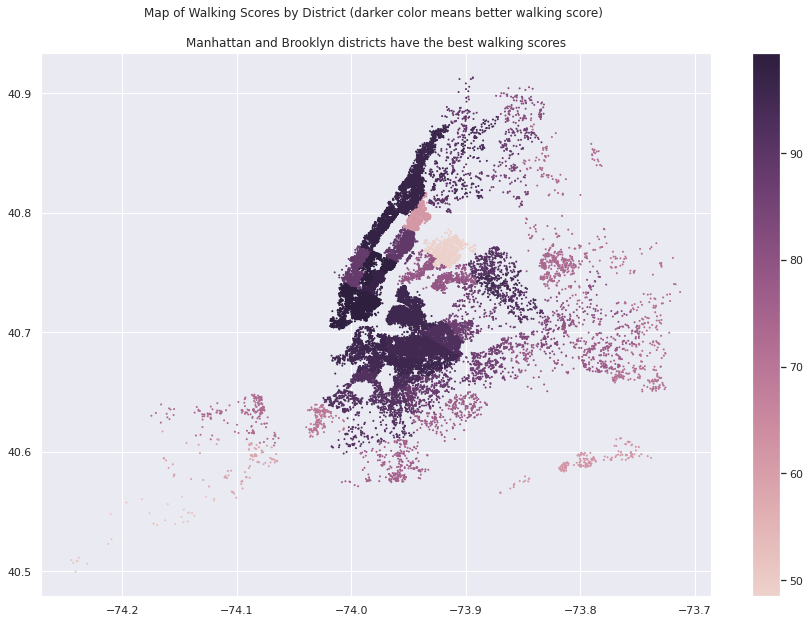

In [ ]:
cmap = sns.cubehelix_palette(as_cmap=True)
sns.set(rc={'figure.figsize':(15,10)})
f, ax = plt.subplots()
points = ax.scatter(listings.longitude, listings.latitude, c=listings.walk, s=1, cmap=cmap)
ax.set_title('''Map of Walking Scores by District (darker color means better walking score) \n
Manhattan and Brooklyn districts have the best walking scores''')
f.colorbar(points)

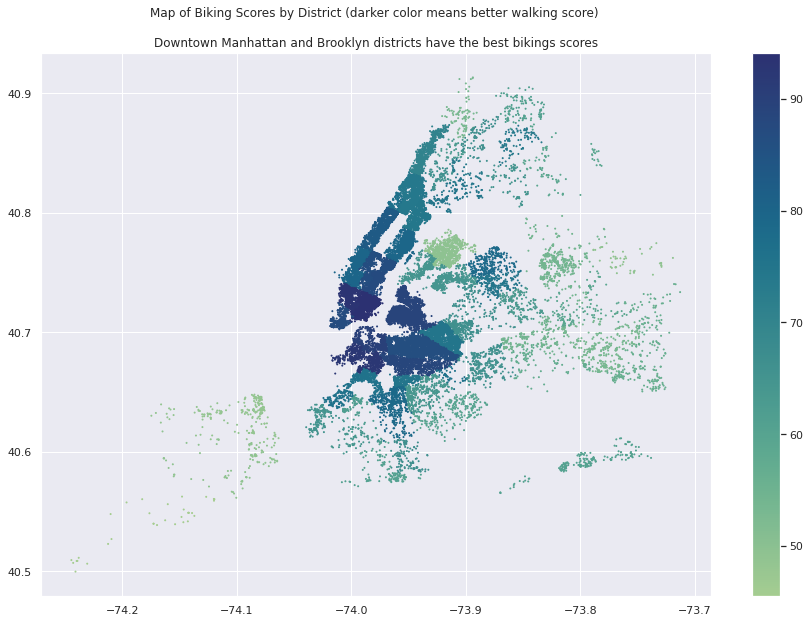

In [ ]:
f, ax = plt.subplots()
points = ax.scatter(listings.longitude, listings.latitude, c=listings.bike, s=1, cmap='crest')
ax.set_title('''Map of Biking Scores by District (darker color means better walking score) \n
Downtown Manhattan and Brooklyn districts have the best bikings scores''')
f.colorbar(points)

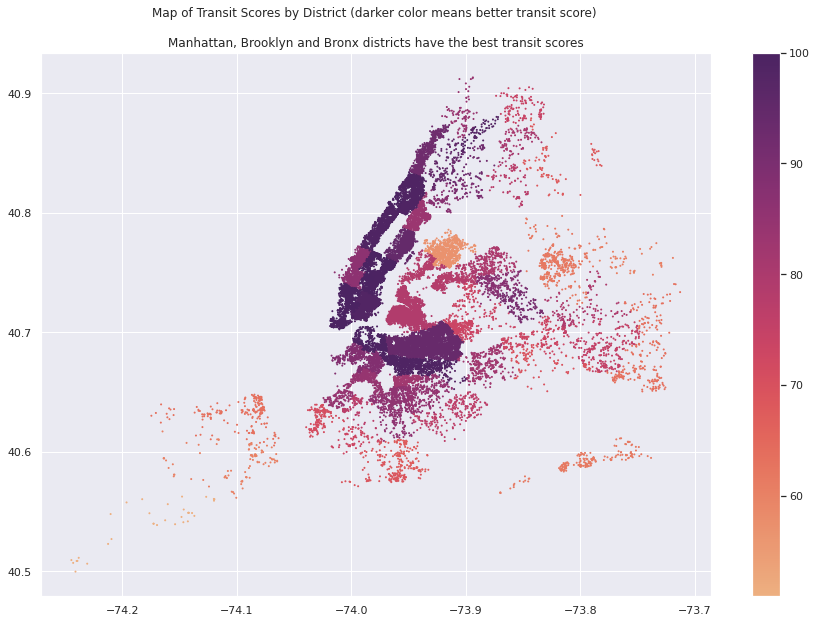

In [ ]:
f, ax = plt.subplots()
points = ax.scatter(listings.longitude, listings.latitude, c=listings.transit, s=1, cmap='flare')
ax.set_title('''Map of Transit Scores by District (darker color means better transit score) \n
Manhattan, Brooklyn and Bronx districts have the best transit scores''')
f.colorbar(points)

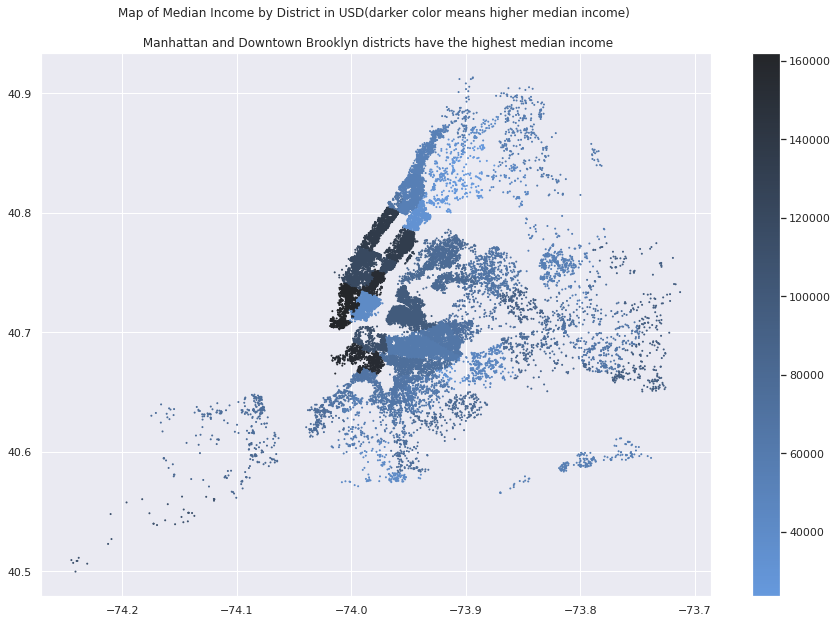

In [ ]:
cmap = sns.dark_palette("#69d", reverse=True, as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(listings.longitude, listings.latitude, c=listings.income, s=1, cmap=cmap)
ax.set_title('''Map of Median Income by District in USD(darker color means higher median income) \n
 Manhattan and Downtown Brooklyn districts have the highest median income''')
f.colorbar(points)

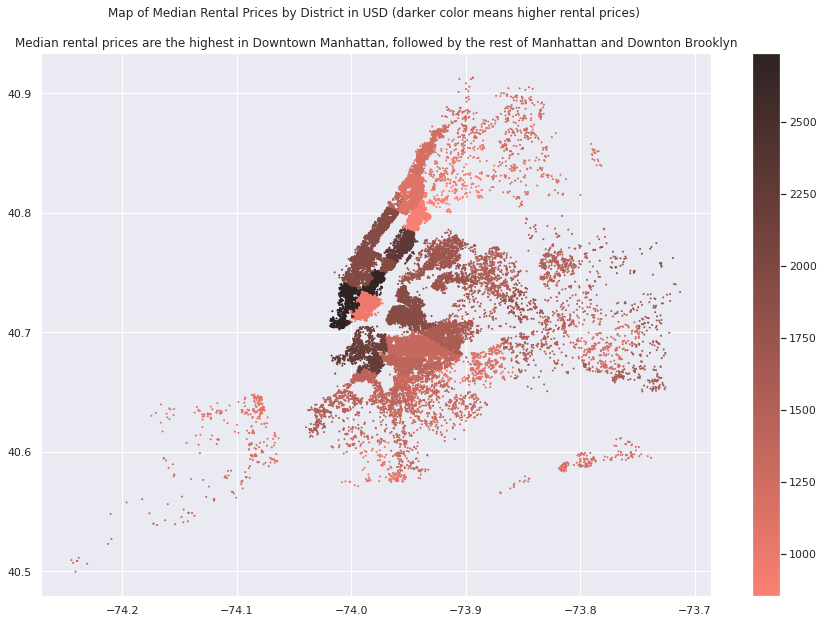

In [ ]:
cmap = sns.color_palette("dark:salmon_r", as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(listings.longitude, listings.latitude, c=listings.rent, s=1, cmap=cmap)
ax.set_title('''Map of Median Rental Prices by District in USD (darker color means higher rental prices) \n
Median rental prices are the highest in Downtown Manhattan, followed by the rest of Manhattan and Downton Brooklyn''')
f.colorbar(points)

Code for UI Options 

In [ ]:
#Drawing an interactive table
#If need to install Styler, use: pip install jinja2

dataframe = pd.DataFrame(
    np.random.randn(10, 20),
    columns=('col %d' % i for i in range(20)))

#st.dataframe(dataframe.style.highlight_max(axis=0))

In [ ]:
#Static Table
dataframe = pd.DataFrame(
    np.random.randn(10, 20),
    columns=('col %d' % i for i in range(20)))
st.table(dataframe)

NameError: ignored

In [ ]:
#Using Slider Widget
x = st.slider('x') #the slider determines the value of x 
st.write(x, 'squared is', x * x)


NameError: ignored

In [ ]:
#Adding a button
click_me = st.button('Click me!')

NameError: ignored

In [ ]:
#Adding drop down menu to sidedbar
add_selectbox = st.sidebar.selectbox(
    'Which neighborhood would you like to view?',
    ('Astoria', 'East Village', 'Kips Bay')
)


NameError: ignored

In [ ]:
#Adding a slide bar to the sidebar
#could use to create price ranges and allow user to choose range
add_slider = st.sidebar.slider(
    'Select a range of values',
    0.0, 100.0, (25.0, 75.0)
)

Streamlit Visualizations

In [ ]:
#calling functions that load our data
data_load_state = st.text('Loading data...')
our_data = name_of_data_table(1000)


In [ ]:
#Histogram
#can adjust range and column names as needed
df = pd.DataFrame(our_data[:200], columns = [‘name_1’,’name_2’,’name_3’])
df.hist()
plt.show()
st.pyplot()

In [ ]:
#Creating Box Plot
#not sure what to do about first line
#may need to adjust indentations based on how it all integrates
if dataset_type == "Classification":
if st.checkbox("Visualize Columns wrt Classes"):
  st.write("#### Select column to visualize: ")
  columns = df.columns.tolist()
  class_name = columns[-1]
  column_name = st.selectbox("",columns)
  st.write("#### Select type of plot: ")
  plot_type = st.selectbox("", ["box"])
  if st.button("Generate"):
    if plot_type == "box":
      st.write(sns.boxplot(x=class_name, y=column_name, palette="husl", data=df))
      st.pyplot()

              